In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize table

In [26]:
learning_rate = 0.001
discount_factor = 0.95
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.001
num_episodes = 1000
max_steps_per_episode = 100
batch_size = 64
memory_size = 10000

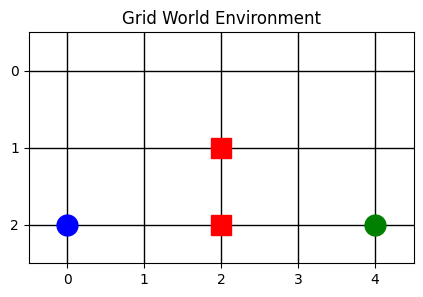

In [27]:
# Define Grid World environment
grid_size = (5,3)
initial_state = (2,0)

# event 
goal_state = (2, 4)
obstacle_states = [(1, 2), (2, 2)]
'''
# event 2
obstacle_states = [(1, 1), (2, 1),
                   (0, 3), (1, 3)]
goal_state = (0, 4)
'''

# Visualize Grid World environment
plt.figure(figsize=(grid_size[0], grid_size[1]))
plt.imshow(np.zeros((grid_size[1], grid_size[0])), cmap='gray', alpha=0)  # Background
plt.xticks(np.arange(grid_size[0]))
plt.yticks(np.arange(grid_size[1]))
plt.grid(True, linewidth=1, color='black')


plt.plot(initial_state[1], initial_state[0], 'bo', markersize=15)
# Visualize goal state
plt.plot(goal_state[1], goal_state[0], 'go', markersize=15)

# Visualize obstacle states
for obstacle in obstacle_states:
    plt.plot(obstacle[1], obstacle[0], 'rs', markersize=15)

plt.title("Grid World Environment")
plt.show()

# Main Function (DQN network)

In [28]:
# Define DQN network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [29]:
input_dim = 2
output_dim = 4
dqn = DQN(input_dim, output_dim)
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [30]:
# Function to choose action (epsilon-greedy policy)
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(output_dim)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = dqn(state_tensor)
        return torch.argmax(q_values).item()

# Function to perform a step in the environment
def step(state, action):
    row, col = state
    if action == 0:
        row = max(0, row - 1)
    elif action == 1:
        row = min(grid_size[1] - 1, row + 1)
    elif action == 2:
        col = max(0, col - 1)
    elif action == 3:
        col = min(grid_size[0] - 1, col + 1)

    next_state = (row, col)

    if next_state == goal_state:
        reward = 1
        done = True
    elif next_state in obstacle_states:
        reward = -1
        done = True
    else:
        reward = 0
        done = False

    return next_state, reward, done

# Training

In [31]:
learning_rate = 0.001
discount_factor = 0.95
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.001
num_episodes = 1000
max_steps_per_episode = 100
batch_size = 64
memory_size = 10000

In [32]:
input_dim = 2
output_dim = 4
dqn = DQN(input_dim, output_dim)
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [33]:
# DQN training
episode_rewards = []
memory = []

for episode in range(num_episodes):
    state = (0, 0)
    done = False
    step_count = 0
    total_reward = 0
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-epsilon_decay * episode)

    while not done and step_count < max_steps_per_episode:
        action = choose_action(state, epsilon)
        next_state, reward, done = step(state, action)

        memory.append((state, action, reward, next_state, done))
        if len(memory) > memory_size:
            memory.pop(0)

        if len(memory) >= batch_size:
            batch = np.random.choice(len(memory), batch_size, replace=False)
            batch_memory = [memory[i] for i in batch]

            states, actions, rewards, next_states, dones = zip(*batch_memory)

            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions).unsqueeze(1)
            rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones).unsqueeze(1)

            q_values = dqn(states_tensor).gather(1, actions_tensor)
            next_q_values = dqn(next_states_tensor).max(1)[0].unsqueeze(1)
            target_q_values = rewards_tensor + discount_factor * next_q_values * (1 - dones_tensor)

            loss = criterion(q_values, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        state = next_state
        total_reward += reward
        step_count += 1

    episode_rewards.append(total_reward)

# Calculate average reward
average_rewards = np.cumsum(episode_rewards) / (np.arange(len(episode_rewards)) + 1)

# Visualization

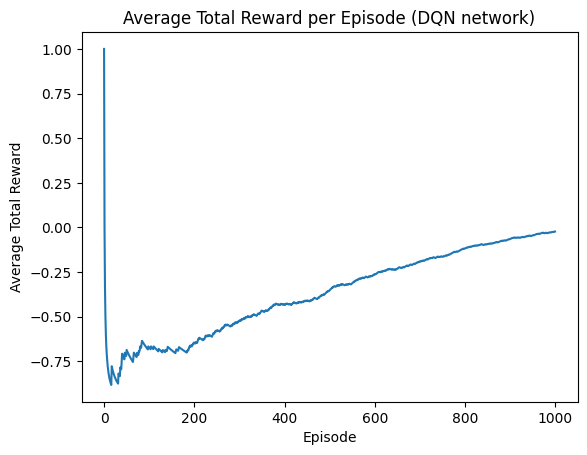

In [34]:
plt.plot(average_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Total Reward")
plt.title("Average Total Reward per Episode (DQN network)")
plt.show()

Path: [(2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (2, 4)]


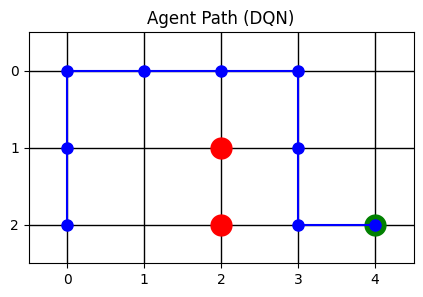

In [35]:
# Test learned agent
state = initial_state
done = False
path = [state]
step_count = 0

while not done and step_count < max_steps_per_episode:
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    q_values = dqn(state_tensor)  # Use DQN network to get Q-values
    action = torch.argmax(q_values).item()
    next_state, reward, done = step(state, action)
    path.append(next_state)
    state = next_state
    step_count += 1

print("Path:", path)

# Visualize agent path
plt.figure(figsize=(grid_size[0], grid_size[1]))
plt.imshow(np.zeros((grid_size[1], grid_size[0])), cmap='gray', alpha=0)
plt.xticks(np.arange(grid_size[0]))
plt.yticks(np.arange(grid_size[1]))
plt.grid(True, linewidth=1, color='black')

plt.plot(goal_state[1], goal_state[0], 'go', markersize=15)

for obstacle in obstacle_states:
    plt.plot(obstacle[1], obstacle[0], 'ro', markersize=15)

path_x = [p[1] for p in path]
path_y = [p[0] for p in path]
plt.plot(path_x, path_y, 'b-o', markersize=8)

plt.title("Agent Path (DQN)")
plt.show()